In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import joblib
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from pathlib import Path
import copy

#Trying out recusive feature elimination to compare with step wise regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn

from progressbar import ProgressBar



import datetime
import calendar


%matplotlib inline

#custom functions
def NSC(y_pred,y_true):
    """
    Nash-Sutcliffe Coefficient
    """
    return 1 - sum((y_pred-y_true)**2)/sum((y_true-np.mean(y_true))**2)




In [4]:

#This is the final dataset to make predictions on
p = Path('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Processed_Training_Data')
#dir_data = 'C:/Users/Ryan/Box/Dissertation/Paper1/Data/Model_Input_Data/Monthly/Input/FinalVars'

slc = {i.stem[0:3] : pd.read_excel(i) for i in p.glob('**/*.xlsx')}

#rename the gpcd column
for i in slc:
    slc[i].rename(columns={i+'_gpcd': 'Obs_gpcd'}, inplace=True)
    slc[i]=slc[i].set_index('Year')
snow=pd.read_excel('C:/Users/Ryan/Box/Dissertation/Paper1/Data/Alta_LCC_snow.xlsx')
snow=snow.set_index('Year')
#need to remove certain features
'''
lots of colinearity between mountain and valley, since we are focused on the valley we will use valley conditions.
meantemp and maxtemps days > are good predictors, however, they will be difficult to predict into the future.
Mill creek and city creek show high colinarity. Since city creek is a source we will remove mill creek.
Removing red butte and emigration creeks as they are not supply streams and show co-linearity
!!! removing the aggregated Seven canyons streamflow. There appears to be a unique climate signial that very well helps
demand forecasting by including the supply streamflows!!!!
Precipitation days is removed as they will be difficult to predict with certainity in the future.
Days above max, mean is removed as its colinear with mean temp and is difficult to predict into future.
Percent are selected, sqmi is basicaly the same
Removed reshousingdensity at it is highly coorelated wiht respopulationdensity
removed Urban_Area_Perc as it has high colinearity with res pop dens
Residential_Area_Perc removed as colinear wiht res pop dens)
'''
colrem= ['Dem_AF', 'seven', 'meantemp_days', 'maxtemp_days', 'mean_max', 'mill', 'precip_days', 
         'Days_abovemax','Days_abovemean', 'red' , 'emig', 'sqmi','max_Days_WO',
         'mtn','ResHouseDensity', 'Urban_Area_Perc','Residential_Area_Perc', 'IrrPopulationDensity',
         'Irrigated_Area_Perc','CityCrk_AcFt_WR_Mar', 'LitCotCrk_AcFt_WR_Jun']#, 'AcFt', 'WO', 'days', 'days', 'above' , 'Perc']


for i in slc:
    for j in colrem:
        slc[i]=slc[i].loc[:,~slc[i].columns.str.contains(j , case=False)] 


In [5]:
#Create training and testing data, use most recent low, average, and high water years
slc_train=copy.deepcopy(slc)
slc_test=copy.deepcopy(slc)

#2008 is a high year
#2011 and 2017 are average years
#2014 and 2016 are below average years
#2015 is a very  low year

IN_WY_Months = ['Jan' , 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct']
Prior_YR_WY_Months = ['Nov', 'Dec']
testWYyrs = [2008,2015,2017]
#testPrioWYyrs = [2007,2014,2016]


for i in slc:
    #Select the training/testing dataframes
    slc_train[i]=slc_train[i][~slc_train[i].index.isin(testWYyrs)]
    slc_test[i]=slc_test[i][slc_test[i].index.isin(testWYyrs)]
   
    


In [6]:
    

#Determine the indoor mean to subtract from outdoor
I_mean_train=(slc_train['Jan']['Obs_gpcd']+
              slc_train['Feb']['Obs_gpcd']+
              slc_train['Mar']['Obs_gpcd']+
              slc_train['Nov']['Obs_gpcd']+
             slc_train['Dec']['Obs_gpcd'])/5
I_mean_test=(slc_test['Jan']['Obs_gpcd']+
             slc_test['Feb']['Obs_gpcd']+
             slc_test['Mar']['Obs_gpcd']+
             slc_test['Nov']['Obs_gpcd']+
             slc_test['Dec']['Obs_gpcd'])/5
#This uses total demand for irrigation seasons
#I_mean_train=np.zeros(23)
#I_mean_test=np.zeros(10)

for i in slc_train:
    slc_train[i]['Iave']=I_mean_train
    #for now include testing years
    slc_test[i]['Iave']=I_mean_test

IrrSeason= ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
colrem=['Iave', 'Obs_gpcd']
#set the target gpcd to indoor for indoor and total-indoor for outdoor
#change to indoor to separate outdoor demands from total
for i in Indoor:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']
    slc_test[i]= slc_test[i].drop(columns=colrem)
    

#Establish outdoor conservation thresholds
O_cons = 0.25
time = 20


for i in IrrSeason:
    slc_train[i]['Target_gpcd']=slc_train[i]['Obs_gpcd']-slc_train[i]['Iave']
    slc_train[i].loc[slc_train[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #add in snow info
    slc_train[i]=pd.concat([slc_train[i], snow], axis=1, join="inner")
    
    slc_train[i]= slc_train[i].drop(columns=colrem)
    #for now include testing years
    slc_test[i]=pd.concat([slc_test[i], snow], axis=1, join="inner")
    slc_test[i]['Target_gpcd']=slc_test[i]['Obs_gpcd']-slc_test[i]['Iave']
    slc_test[i].loc[slc_test[i]['Target_gpcd'] < 0, 'Target_gpcd'] = 0
    
    #create monthly historical mean and conservation trends
    Out_mean = np.mean(slc_train[i]['Target_gpcd'].loc[2000:])
    goal = (1-O_cons)*Out_mean
    O_cons_rate = (Out_mean -goal)/time
    


    slc_train[i]['cons_goal'] = Out_mean- ((slc_train[i].index-2000)*O_cons_rate)
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Out_mean
    
    t=slc_train[i]['Target_gpcd'].copy()
    c=slc_train[i]['cons_goal'].copy()
    slc_train[i] = slc_train[i].drop(columns=['Target_gpcd', 'cons_goal'])
    slc_train[i]['Target_gpcd'] = t
    slc_train[i]['cons_goal'] = c
    
    slc_test[i]['cons_goal'] = Out_mean - ((slc_test[i].index-2000)*O_cons_rate) 
    
 
    
    
    slc_test[i]= slc_test[i].drop(columns=colrem)

    
#Determine the historical indoor mean to apply conservation strategies too
Indmean = np.mean(slc_train['Jan']['Target_gpcd'].loc[2000:]+
                  slc_train['Feb']['Target_gpcd'].loc[2000:]+
                  slc_train['Mar']['Target_gpcd'].loc[2000:]+
                  slc_train['Nov']['Target_gpcd'].loc[2000:]+
                 slc_train['Dec']['Target_gpcd'].loc[2000:])/5
'''Per UDWR 2001, Utah's Water Resources: Planning for the future, the govenor ordered a
25% reduction in water use by 2025
'''
cons = 0.28

goal = (1-cons)*Indmean

time = 20

cons_rate = (Indmean -goal)/time

#print(cons_rate , goal)

#create feature called cons_goal!
for i in Indoor:
    slc_test[i]['cons_goal'] = Indmean-((slc_test[i].index-2000)*cons_rate) 
    slc_train[i]['cons_goal'] = Indmean-((slc_train[i].index-2000)*cons_rate) 
    
    slc_train[i].loc[ slc_train[i].index <2000, ['cons_goal']] = Indmean
    
    
Cons_mean_test=(slc_test['Jan']['cons_goal']+
                slc_test['Feb']['cons_goal']+
                slc_test['Mar']['cons_goal']+
                slc_test['Nov']['cons_goal']+
                slc_test['Dec']['cons_goal'])/5

#split training and testing data into features and targets
slc_train_target=copy.deepcopy(slc_train)
slc_train_features=copy.deepcopy(slc_train)

slc_test_target=copy.deepcopy(slc_test)
slc_test_features=copy.deepcopy(slc_test)


target=['Target_gpcd','Housing']
for i in slc_train_target:
    slc_train_target[i]=slc_train_target[i]['Target_gpcd']
    #for now include testing years
    slc_test_target[i]=slc_test_target[i]['Target_gpcd']


    slc_train_features[i]= slc_train_features[i].drop(columns=target)
    #for now include testing years
    slc_test_features[i]= slc_test_features[i].drop(columns=target)
    
#need to remove year from the list to run plots below
for i in slc_train:
    slc_train[i]=slc_train[i].drop(columns=['Housing',  'Population', 'PopulationDensity'])


In [7]:
'''
We want to see the trends for the training data,# and will want to have them modeled into the future based
on consevation goals

From plots, There appears to be very little trends in training data. The last 10 years do show decreasing trends
likely due to conservation goals estabished in 2005


Thinking of a stepwise process:
1) identify any trends (training and testing): check, no trends in training. however in 2000, Utah established a 
   conservation goal. To reduce the gpcd water use by 25% by 2025. Evaluating water use from 2005-2017 shows a decline
   in water use.
2) Determine conservation goals (annual reduction /yr, slope), over 25yrs a 75 gpcd reduction is requested (3gpcd/yr), check
3) Separately model indoor and outdoor demands per year. check 
4) Training Outdoor demand (Apr-Oct) will be that month's total demand minus that years Jan-Mar mean indoor demand
5) Final model = modeled indoor demand - conservation reduction + Outdoor demand (if Apr-Oct).
'''

def Outdoor_Demand_Model(TrainDF, month, X_train_features, y_train_target, X_test_features, y_test_target,
                          snowfeatures, conservation, cor_threshold, colinearity_thresh, cv_splits,
                         model_type, scoring ):
  

#subset these features out of main DF and put into cute heatmap plot
    
    DFcor = copy.deepcopy(TrainDF[month])
    
    #if snowfeatures is True:
     #   print('LCC Snowfeatures are being used')
    if snowfeatures is False:
        snow=['Nov_snow_in','Dec_snow_in', 'Jan_snow_in','Feb_snow_in', 
              'Mar_snow_in','Apr_snow_in', 'Total_snow_in', 'Snow_shortage']
        DFcor=DFcor.drop(columns=snow)

    
    cor=DFcor.copy()
    if conservation is False:
        del cor['cons_goal']
        cor = cor.corr()
        cor =cor.iloc[:,-1:]
    if conservation is True:
        cor = cor.corr()
        cor =cor.iloc[:,-2:]
        del cor['cons_goal']
        
    cor['Target_gpcd']=np.abs(cor['Target_gpcd'])
    cor=cor.sort_values(by=['Target_gpcd'], ascending=False)
    cor=cor.dropna()

#Selecting highly correlated features
    relevant_features = cor[cor['Target_gpcd']>cor_threshold]
    CorFeat = list(relevant_features.index)

    CorDF= DFcor[CorFeat]
    cor = np.abs(CorDF.corr())
    cor = cor.mask(np.tril(np.ones(cor.shape)).astype(np.bool))
    #remove colinearity
    cor = cor[cor.columns[cor.max() < colinearity_thresh]]
    CorFeat=cor.columns
    cor = cor.T
    cor = cor[CorFeat]
    
    #print('Remaining features are', CorFeat)

    
   #Set up training and testing data 
    X_train = X_train_features[month][CorFeat].copy()
#X_train = slc_train_features['Jul'][JulF]
    y_train = y_train_target[month].copy()

    X_test = X_test_features[month][CorFeat].copy()
#X_test = slc_test_features['Jul'][JulF]
    y_test = y_test_target[month].copy()

    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = cv_splits, shuffle = True, random_state = 42)

# step-2: specify range of hyperparameters to tune
    if len(CorFeat) > 1 :
        hyper_params = [{'n_features_to_select': list(range(1, len(CorFeat)))}]
        

# step-3: perform grid search
# 3.1 specify model, key to set intercept to false
        trainmodel = model_type
        trainmodel.fit(X_train, y_train)
        rfe = RFE(trainmodel)             

# 3.2 call GridSearchCV()
        model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= scoring, 
                        cv = folds, 
                        verbose = 0,
                        return_train_score=True)      

# fit the model
        model_cv.fit(X_train, y_train)

# create a KFold object with 5 splits 
        folds = KFold(n_splits = cv_splits, shuffle = True, random_state = 42)
        scores = cross_val_score(trainmodel, X_train, y_train, scoring=scoring, cv=folds)
       # print('CV scores = ', scores) 

# cv results
        cv_results = pd.DataFrame(model_cv.cv_results_)

    
     #code to select features for final model, tell how many features
        N_feat=cv_results.loc[cv_results['mean_test_score'].idxmax()]
        N_feat=N_feat['param_n_features_to_select']
        #print('Number of features to select is ', N_feat)
    # intermediate model
        n_features_optimal = N_feat

        Int_model = model_type
        Int_model.fit(X_train, y_train)

        rfe = RFE(Int_model, n_features_to_select=n_features_optimal)             
        rfe = rfe.fit(X_train, y_train)

#make the final model with rfe features

# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features

        Features =list(zip(X_train.columns,rfe.support_,rfe.ranking_))
        FeaturesDF=pd.DataFrame(Features, columns=['Feature', 'Important', 'Score'])
        FeaturesDF = FeaturesDF[FeaturesDF.Score<=1]
        RFE_features = list(FeaturesDF['Feature'])
       # print('The final features are ', RFE_features)
        
        #select only RFE features for model training/validation
        X_train = X_train[RFE_features]
        X_test = X_test[RFE_features]

    
    #plot of selected features to make sure not colinear
        CorDF= X_train.copy()
        CorDF['Target_gpcd']=slc_train[month]['Target_gpcd']

        Final_model = model_type
        Final_model.fit(X_train, y_train)
        
   
        
    else:
          
       #Set up training and testing data to have a random non-correlated feature then
        X_train = X_train_features[month]['HousingDensity'].copy()
        X_test = X_test_features[month]['HousingDensity'].copy()
        cv_results = 0
        cor = 0
        
        len1 = len(X_train)
        len2 = len(X_test)
        
        X_train = np.array(X_train).reshape(len1, 1)
        X_test = np.array(X_test).reshape(len2, 1)
        
        Final_model = model_type
        Final_model.fit(X_train, y_train)
        
    # Get training data model performance to tune hyperparameters
    yt_pred = Final_model.predict(X_train)
    
    yt_pred = [0 if x < 0 else x for x in yt_pred]
    O_r2_train = sklearn.metrics.r2_score(y_train, yt_pred)
    O_rmse_train = sklearn.metrics.mean_squared_error(y_train, yt_pred, squared = False)
   
# predict X_test
    y_pred = Final_model.predict(X_test)
    
    y_pred = [0 if x < 0 else x for x in y_pred]
    O_r2_test = sklearn.metrics.r2_score(y_test, y_pred)
    O_rmse_test = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
    
 

#plot the predictions
    PerfDF=pd.DataFrame(list(zip(y_pred, y_test)), columns=['y_pred', 'y_test'])

#Add indoor demands
    Indoor=['Jan', 'Feb', 'Mar', 'Nov', 'Dec']
    if month in Indoor:
        PerfDF['y_test']=PerfDF['y_test']
        PerfDF['y_pred']=PerfDF['y_pred']
    else:
        PerfDF['y_test_tot']=PerfDF['y_test']+list(I_mean_test)
        PerfDF['y_pred_tot']=PerfDF['y_pred']+list(Cons_mean_test)

    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'], PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'], PerfDF['y_pred_tot'], 
                                               squared = False)

    #print('Total R2 is ', T_r2)
    #print('Total rmse is ', T_rmse)
  

    PerfDF['Year'] = list(slc_test['Jul'].index)
    PerfDF=PerfDF.set_index('Year')
   

    datetime_object = datetime.datetime.strptime(month, "%b")
    PerfDF['month'] = datetime_object.month
    PerfDF['Year']=PerfDF.index
   
    
    #set up dates so all months can be combined and sorted
    day=[]
    for index, row in PerfDF.iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    PerfDF['Day']=day
  
    PerfDF['Date'] = pd.to_datetime(PerfDF[['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    PerfDF=PerfDF.drop(columns=['Year', 'month', 'Day'])
    PerfDF=PerfDF.reset_index()
    
    params = [snowfeatures, conservation, cor_threshold, colinearity_thresh]
    
    return X_test, PerfDF, O_rmse_train, O_r2_train ,O_rmse_test, O_r2_test , params, cv_results, cor , Final_model.coef_

In [8]:
def Indoor_Demand_Model(df, month):
    #Make matching indoor demand model
    datetime_object = datetime.datetime.strptime(month, "%b")
    df[month]['month'] = datetime_object.month
    
    df[month]['Year']=df[month].index
    
     #set up dates so all months can be combined and sorted
    day=[]
    for index, row in df[month].iterrows():
        day.append(calendar.monthrange(int(row['Year']), int(row['month']))[1])
    
    df[month]['Day']=day
    
  
    df[month]['Date'] = pd.to_datetime(df[month][['Year', 'month', 'Day']])
    
    #PerfDF=PerfDF.set_index('Date')
    df[month]=df[month].drop(columns=['month', 'Day'])
    df[month]=df[month].reset_index(drop=True)
   
    
    colrem = slc_test[i].columns
    df[month]['y_pred'] =  df[month]['cons_goal']
    df[month]['y_test'] =  df[month]['Target_gpcd']
    df[month]['y_pred_tot'] =  df[month]['cons_goal']
    df[month]['y_test_tot'] =  df[month]['Target_gpcd']
       
    df[month] = df[month].set_index('Date')
    
    df[month] = df[month].drop(columns=colrem)
    
    return df

In [9]:
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral')
    ax.axis([xmin, xmax, ymin, ymax])


In [10]:
def model_plots(PerfDF, cv_results,cor, X_test_RFE, coef, scoring, month):
    
    plotmin = PerfDF[['y_pred', 'y_test']].min().min()
    plotmax = PerfDF[['y_pred', 'y_test']].max().max()
    
    plotmin_tot = PerfDF[['y_pred_tot', 'y_test_tot']].min().min()
    plotmax_tot = PerfDF[['y_pred_tot', 'y_test_tot']].max().max()
    
    # plotting cv results
    plt.figure(figsize=(12,10))
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_corMatrix.pdf')
    plt.show()
    
    fig, ax = plt.subplots(3,3, constrained_layout=True)
    fig.set_size_inches(9,10)


    ax[0,0].plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    ax[0,0].plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    ax[0,0].set_xlabel('number of features')
    ax[0,0].set_ylabel(scoring)
    ax[0,0].set_title("Optimal Number of Features")
    ax[0,0].legend(['test score', 'train score'], loc='upper left')
    ax[0,0].spines['bottom'].set_color('black')
    ax[0,0].spines['left'].set_color('black')

    ax[0,1].scatter(PerfDF['y_test'], PerfDF['y_pred'],color='blue', alpha=0.5)
    ax[0,1].set_ylabel('Predicted')
    ax[0,1].set_xlabel('Observed')
    ax[0,1].set_ylim(plotmin-5,plotmax+5)
    ax[0,1].set_xlim(plotmin-5,plotmax+5)
    ax[0,1].set_title('Outdoor Model Performance')
    ax[0,1].plot([plotmin,plotmax],[plotmin,plotmax], color='red', linestyle='--' )
    ax[0,1].spines['bottom'].set_color('black')
    ax[0,1].spines['left'].set_color('black')
    
    ax[0,2].scatter(PerfDF['y_test_tot'], PerfDF['y_pred_tot'],color='blue', alpha=0.5)
    ax[0,2].set_ylabel('Predicted')
    ax[0,2].set_xlabel('Observed')
    ax[0,2].set_ylim(plotmin_tot-5,plotmax_tot+5)
    ax[0,2].set_xlim(plotmin_tot-5,plotmax_tot+5)
    ax[0,2].set_title('Indoor and Outdoor \n Model Performance')
    ax[0,2].plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    ax[0,2].spines['bottom'].set_color('black')
    ax[0,2].spines['left'].set_color('black')

    
    
    
    gs = ax[1, 1].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()

    PerfDF['Error'] = (PerfDF['y_pred']-PerfDF['y_test'])
    axbig1 = fig.add_subplot(gs[1, :])
    axbig1.set_title(month+' Outdoor demand Timeline Evaluation')
    axbig1.axhline(y = 0 , color = 'black')
    #axbig1.bar(PerfDF.index, PerfDF['y_pred'], color='orange', label='Predicted')
    Error1 = axbig1.bar(PerfDF.index, PerfDF['Error'],color='blue', label='Prediction Error')
    axbig1.set_xlabel('Year')
    axbig1.set_ylabel('Error (GPCD)')
    axbig1.spines['bottom'].set_color('black')
    axbig1.spines['left'].set_color('black')
    gradientbars_sliced(Error1)
    
    
    gs2 = ax[2, 1].get_gridspec()
    # remove the underlying axes
    ax[2,0].remove()
    ax[2,1].remove()
    ax[2,2].remove()

    #create error value
    PerfDF['Error_tot'] = (PerfDF['y_pred_tot']-PerfDF['y_test_tot'])
    
    axbig2 = fig.add_subplot(gs2[2, :])
    axbig2.set_title(month+' Total Demand Error Timeline Evaluation')
    Error2 = axbig2.bar(PerfDF.index, PerfDF['Error_tot'], color='blue', label='Predicted')
    axbig2.axhline(y = 0 , color = 'black')
    #axbig2.bar(PerfDF.index, PerfDF['y_test_tot'],color='blue', label='Observed')
    axbig2.set_xlabel('Year')
    axbig2.set_ylabel('Error (GPCD)')
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    gradientbars_sliced(Error2)
    
    fig.suptitle(month+ ' Evaluation', size = 16)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_demand.pdf')    
    
    O_r2 = sklearn.metrics.r2_score(PerfDF['y_test'],PerfDF['y_pred'])
    O_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test'],PerfDF['y_pred'], squared = False)
    O_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test'],PerfDF['y_pred'])
    O_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test'],PerfDF['y_pred'])
    
    T_r2 = sklearn.metrics.r2_score(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_rmse= sklearn.metrics.mean_squared_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(PerfDF['y_test_tot'],PerfDF['y_pred_tot'])
    
    print('The outdoor Demand prediction RMSE is ', O_rmse)
    print('The outdoor Demand prediction R2 is ', O_r2)
    
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%')                                                       
    
    print('The final set of features for ' + month + ' are', list(X_test_RFE.columns))
    print('The coefficients for each feature are', coef)
    #set DF up so that all months can be easily combined, basically year-month index

In [11]:
#make an optimization function
#put in your parameter dictionary, month of interest, and scoring method (RMSE or R2)
def Demand_Optimization(Param_dict, month, scoring):
    print('The automated algorithm automatically optimizes the respective model by looping over input parameters within')
    print('the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with')
    print('less correlation to the target.')
    param_list = []
    performance_list=[]
    for i in Param_dict['snowfeatures']:
   #     print('Snowfeatures is ' + str(i))
        for j in Param_dict['conservation']:
    #        print('Conservation is ' + str(j))
            for k in Param_dict['cor_threshold']:
     #           print('Correlation threshold: ', k)
                #pbar = ProgressBar()
                for l in Param_dict['colinearity_thresh']:
      #              print('Colinearity threshold: ', l)
                    X_test_RFE, PerfDF, O_rmse_train,O_r2_train, O_rmse_test, O_r2_test, params, cv_results, cor, coef = Outdoor_Demand_Model(slc_train, month, 
                            slc_train_features, slc_train_target, slc_test_features,slc_test_target, 
                            snowfeatures= i, conservation = j, cor_threshold = k, colinearity_thresh = l, cv_splits = 5,
                            model_type = linear_model.Ridge(fit_intercept = False, alpha=1), 
                            scoring = 'neg_root_mean_squared_error')
                    param_list.append(params)
                    if scoring =='R2':
                        performance_list.append(O_r2_test)
                    if scoring =='RMSE':
                        performance_list.append(O_rmse_test)
                        
      
                    
    #take model performances and put into DF so they can be joined and sorted                
    ParamDF = pd.DataFrame(param_list, columns =list(Param_dict.keys()))
    PerfDF = pd.DataFrame(performance_list, columns =[scoring])     
    ParamEval = pd.concat([ParamDF, PerfDF], axis=1)  
    
    if scoring =='R2':
        ParamEval = ParamEval.sort_values(by=[scoring], ascending = False)
    else:
        ParamEval = ParamEval.sort_values(by=[scoring])
    
    #select the first row of parameters as this is the one that shows the greatest performance
    ParamEval=ParamEval.head(1)
    
    X_test_RFE, PerfDF, O_rmse_train,O_r2_train,O_rmse_test, O_r2_test, params, cv_results, cor, coef = Outdoor_Demand_Model(slc_train, month, 
                            slc_train_features, slc_train_target, slc_test_features,slc_test_target, 
                            snowfeatures= list(ParamEval['snowfeatures'])[0] , 
                            conservation = list(ParamEval['conservation'])[0],
                            cor_threshold = list(ParamEval['cor_threshold'])[0],
                            colinearity_thresh = list(ParamEval['colinearity_thresh'])[0],
                            cv_splits = 5, model_type = linear_model.Ridge(fit_intercept = False, alpha=1), 
                            scoring = 'neg_root_mean_squared_error')
    model_plots(PerfDF, cv_results, cor, X_test_RFE, coef,  scoring, month)
    print('The best training parameters are below with their scoring method: ', scoring)
    print(ParamEval)
    return  PerfDF, cv_results, cor, X_test_RFE, coef

In [12]:

#Make a function to put all of the predictions together
def Demand_Forecast(prediction_dictionary, pdict, df, pred, test, units, plotname, model):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in prediction_dictionary:
            FinalDF=FinalDF.append(prediction_dictionary[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('no')
        FinalDF = df
        
    months = np.arange(1,6,1)
    Low = list()
    Ave=list()
    High = list()
    for i in months:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
        
    Low.append('Drought')
    Ave.append('Average')
    High.append('Surplus')
    
    months2 = np.arange(7,13,1)
    for i in months2:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
    
    Conditions = High+Low+Ave

    #adjust date range to improve figure
    #FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']

    


    plotmin_tot = FinalDF[[pred, test]].min().min()
    plotmax_tot = FinalDF[[pred, test]].max().max()

    fig, ax = plt.subplots(1,5, constrained_layout=True)
    fig.set_size_inches(12,4)

    gs2 = ax[0].get_gridspec()
    # remove the underlying axes
    ax[0].remove()
    ax[1].remove()
    ax[2].remove()
    axbig = fig.add_subplot(gs2[:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    axbig.plot(FinalDF[pred], color='orange', label= model)
    axbig.plot(FinalDF[test],color='blue', label='Observed')
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot-.9,plotmax_tot*1.2)
    axbig.set_ylabel('Demand ('+ units+')')
    axbig.legend(loc = 'upper left')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        if i%12 != 5:
            tick.label1.set_visible(False)

    ax[3].remove()
    ax[4].remove()


    axbig2 = fig.add_subplot(gs2[3:])
    axbig2.scatter(FinalDF[test], FinalDF[pred],color='blue', alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units+')' )
    axbig2.set_xlabel('Observed (' + units+')')
    axbig2.set_ylim(plotmin_tot*.95,plotmax_tot*1.2)
    axbig2.set_xlim(plotmin_tot*.95,plotmax_tot*1.2)
   # axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot,plotmax_tot],[plotmin_tot,plotmax_tot], color='red', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    #ax[2].set_aspect('equal', adjustable='box')

    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'.pdf')
    r2 = sklearn.metrics.r2_score(FinalDF[test], FinalDF[pred])
    MAE= sklearn.metrics.mean_absolute_error(FinalDF[test], FinalDF[pred])
    RMSE= sklearn.metrics.mean_squared_error(FinalDF[test], FinalDF[pred], squared = False)
    MAPE=np.mean(np.abs((FinalDF[test]- FinalDF[pred])/FinalDF[test])*100)

    print('Total R2 is ', r2)
    print('Total MAE is ', MAE)
    print('Total RMSE is ', RMSE)
    print('Total MAPE is ', MAPE)
    
    FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']
    
    return FinalDF

The model is automatically selecting features and calibrating the  Apr outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity between features, removing the one with
less correlation to the target.


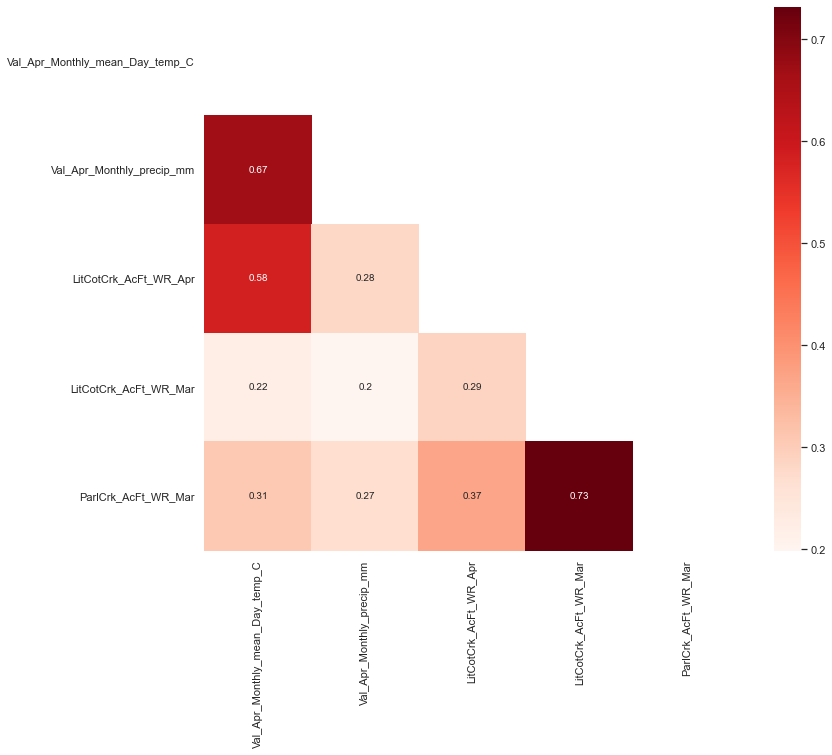

The outdoor Demand prediction RMSE is  10.091412513931665
The outdoor Demand prediction R2 is  0.1876987417608621
The Total Demand prediction RMSE is  13.268172887056254
The Total Demand prediction R2 is  0.32903540800937014
The Total Demand prediction MAE is  13.216378923217809
The Total Demand prediction MAPE is  0.09463600480450761 %
The final set of features for Apr are ['Val_Apr_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_precip_mm', 'LitCotCrk_AcFt_WR_Apr', 'LitCotCrk_AcFt_WR_Mar']
The coefficients for each feature are [ 5.63580354 -0.30790015  0.0073984  -0.01200673]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
285         False         False           0.25                 0.8  10.091413
The model is automatically selecting features and calibrating the  May outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input paramete

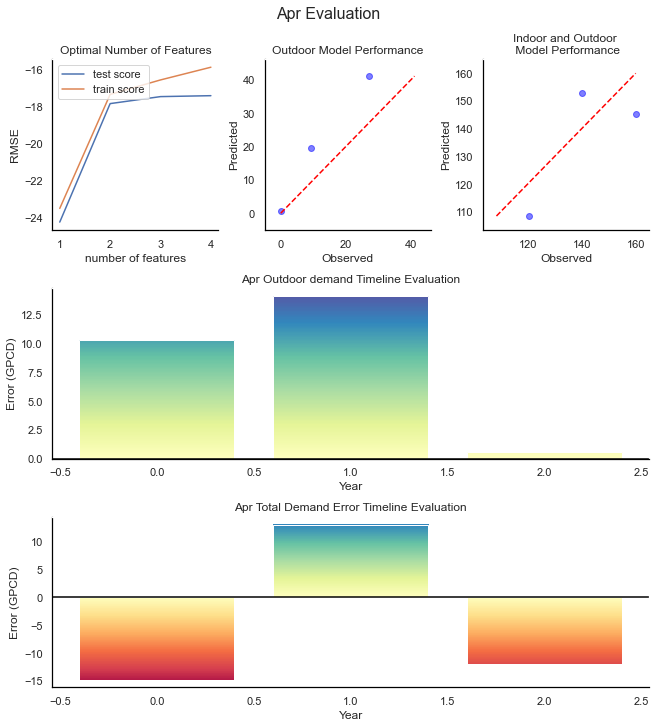

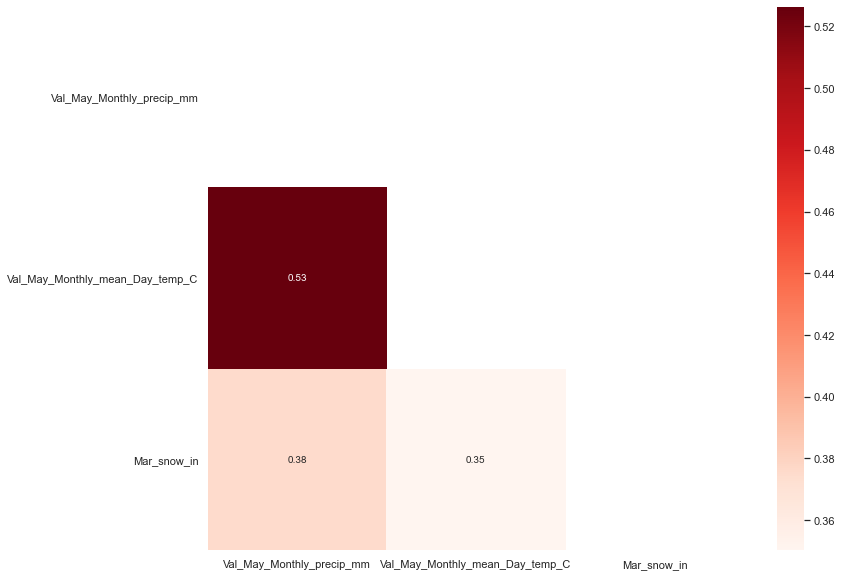

The outdoor Demand prediction RMSE is  26.59450035759143
The outdoor Demand prediction R2 is  0.24753993784999162
The Total Demand prediction RMSE is  21.55771350687681
The Total Demand prediction R2 is  0.7636078896058817
The Total Demand prediction MAE is  19.389179633584718
The Total Demand prediction MAPE is  0.08737087552311436 %
The final set of features for May are ['Val_May_Monthly_precip_mm', 'Val_May_Monthly_mean_Day_temp_C']
The coefficients for each feature are [-1.04939159 14.28103895]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh     RMSE
143          True         False           0.45                 0.9  26.5945
The model is automatically selecting features and calibrating the  Jun outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameters within
the training data. In addiiton, the algorithm checks for colinearity b

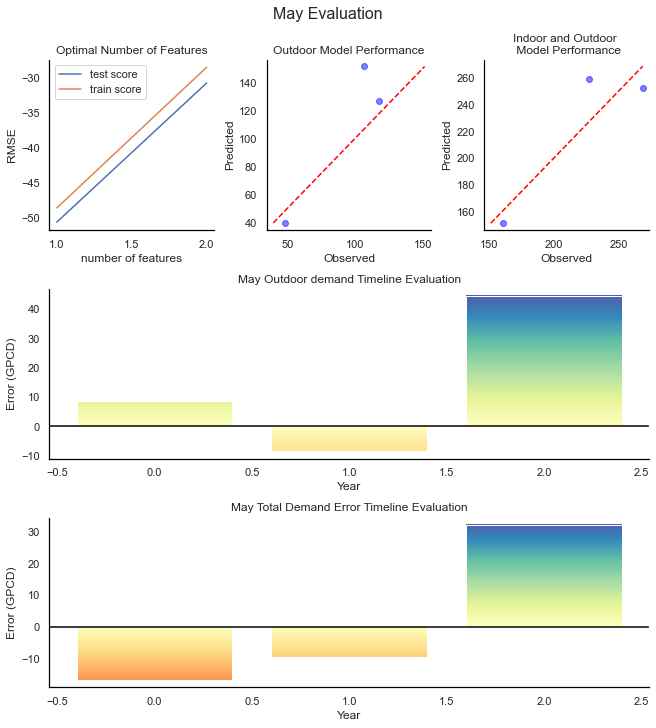

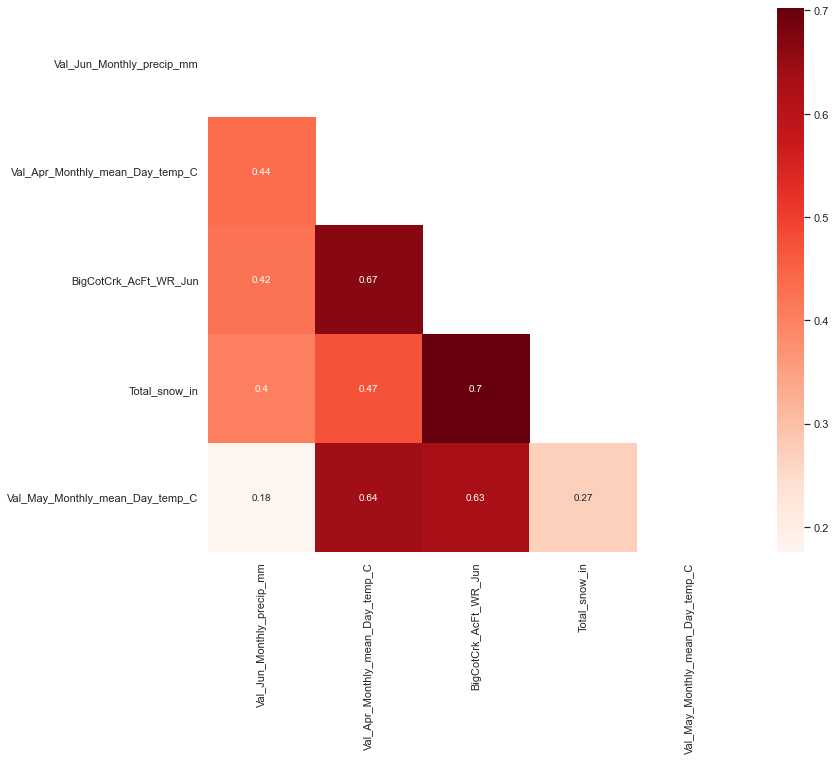

The outdoor Demand prediction RMSE is  17.425846461104445
The outdoor Demand prediction R2 is  0.623344921813956
The Total Demand prediction RMSE is  27.50513462914986
The Total Demand prediction R2 is  0.09908431953793373
The Total Demand prediction MAE is  24.78847358813916
The Total Demand prediction MAPE is  0.06050822126230424 %
The final set of features for Jun are ['Val_Jun_Monthly_precip_mm', 'Val_Apr_Monthly_mean_Day_temp_C', 'Total_snow_in', 'Val_May_Monthly_mean_Day_temp_C']
The coefficients for each feature are [-1.98521823  8.94782618  0.11946181 14.90519373]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
136          True         False            0.4                0.85  17.425846
The model is automatically selecting features and calibrating the  Jul outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over input parameter

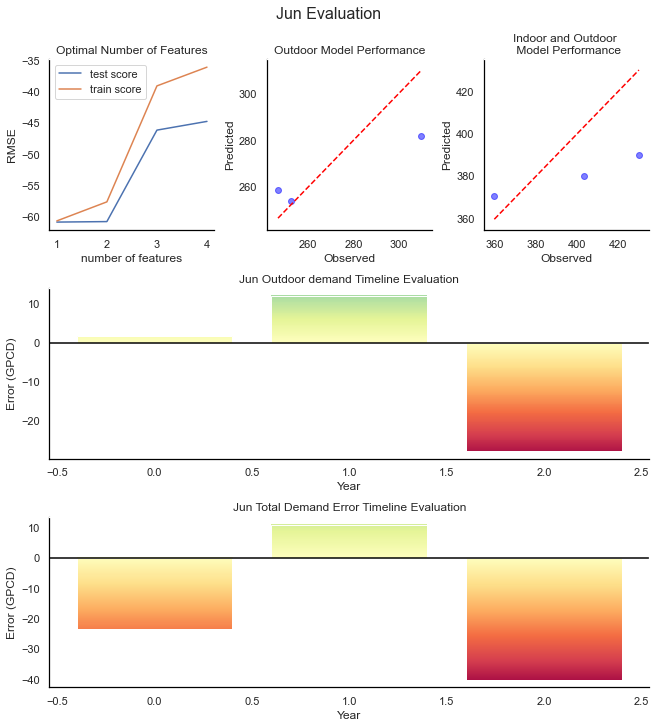

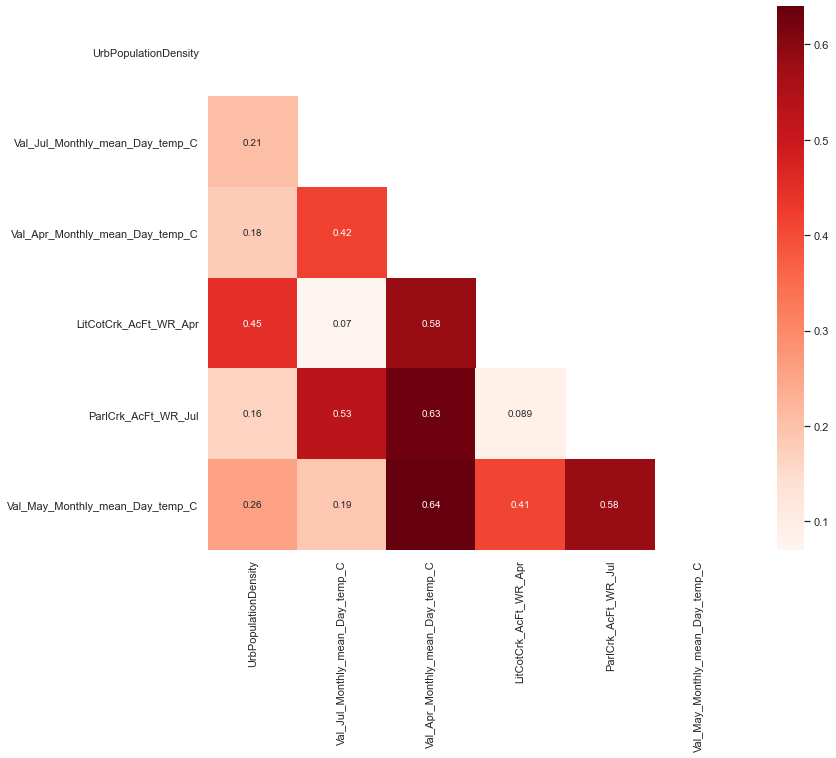

The outdoor Demand prediction RMSE is  18.997649796041955
The outdoor Demand prediction R2 is  0.7296490500037287
The Total Demand prediction RMSE is  10.38453139290509
The Total Demand prediction R2 is  0.9514530601835467
The Total Demand prediction MAE is  9.38337205169241
The Total Demand prediction MAPE is  0.021094176864790506 %
The final set of features for Jul are ['UrbPopulationDensity', 'Val_Jul_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C', 'Val_May_Monthly_mean_Day_temp_C']
The coefficients for each feature are [-0.07505973 31.14216318 -3.91199583  9.54456925]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh      RMSE
283         False         False           0.25                 0.7  18.99765
The model is automatically selecting features and calibrating the  Aug outdoor demand model.
The automated algorithm automatically optimizes the respective model by looping over inpu

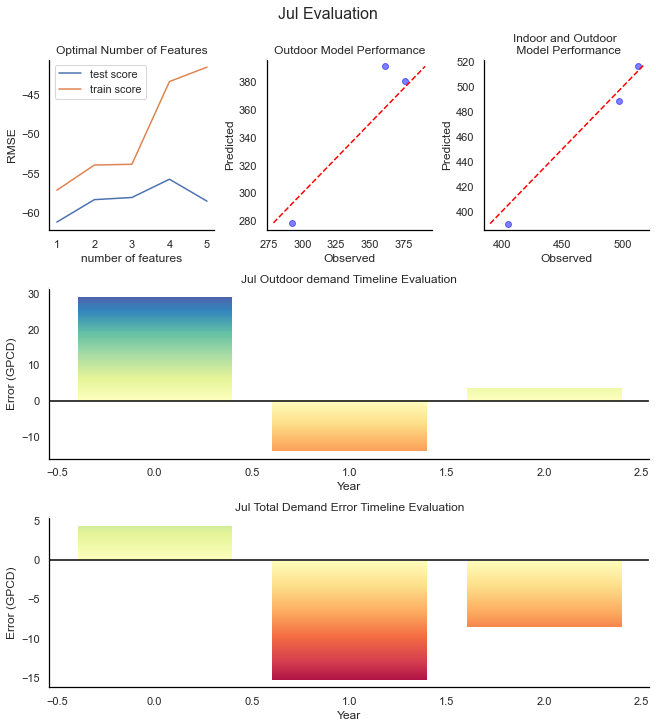

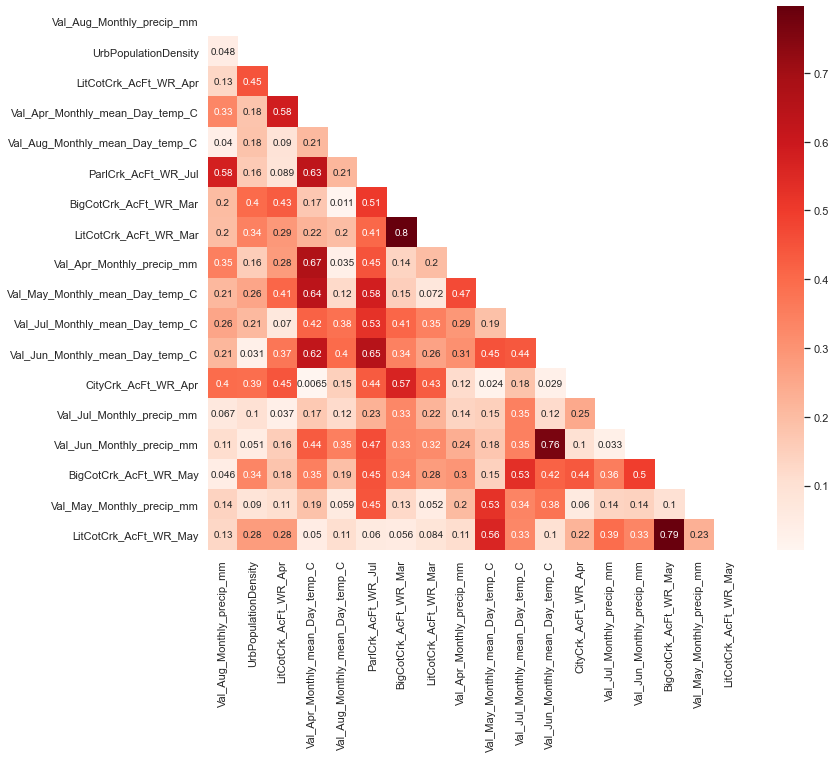

The outdoor Demand prediction RMSE is  37.75960403765589
The outdoor Demand prediction R2 is  0.2613483429291603
The Total Demand prediction RMSE is  26.803285577731657
The Total Demand prediction R2 is  0.7869311763314432
The Total Demand prediction MAE is  25.576755284673066
The Total Demand prediction MAPE is  0.06301563370257961 %
The final set of features for Aug are ['Val_Aug_Monthly_precip_mm', 'UrbPopulationDensity', 'LitCotCrk_AcFt_WR_Apr', 'Val_Apr_Monthly_mean_Day_temp_C', 'Val_Aug_Monthly_mean_Day_temp_C', 'LitCotCrk_AcFt_WR_Mar', 'Val_Apr_Monthly_precip_mm', 'Val_May_Monthly_mean_Day_temp_C', 'Val_Jul_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_precip_mm', 'BigCotCrk_AcFt_WR_May', 'LitCotCrk_AcFt_WR_May']
The coefficients for each feature are [-1.81635380e+00 -3.16349847e-02  6.32041057e-03  6.30736831e+00
  1.50479154e+01  1.07992194e-02 -2.87978896e-01  1.14849889e+01
  1.44172944e+00  1.22865885e+00  4.07734087e-01  1.41719261e-02
 -2.3

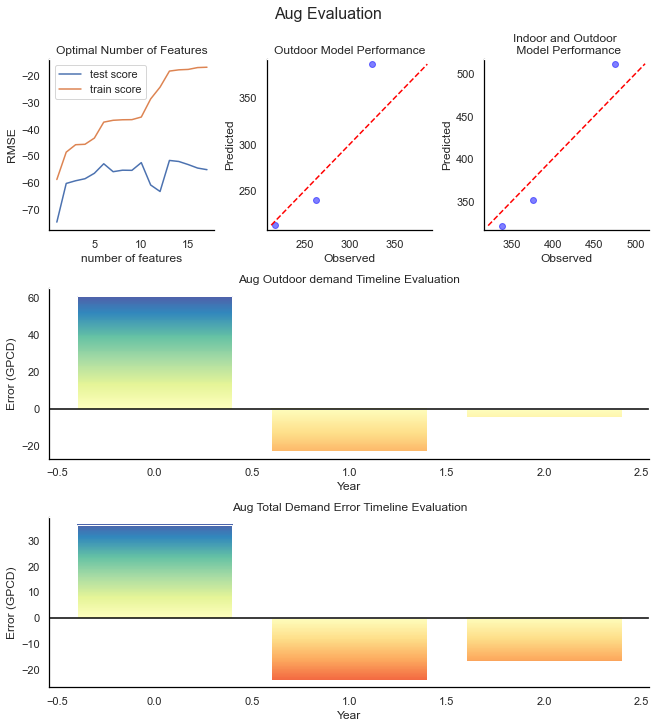

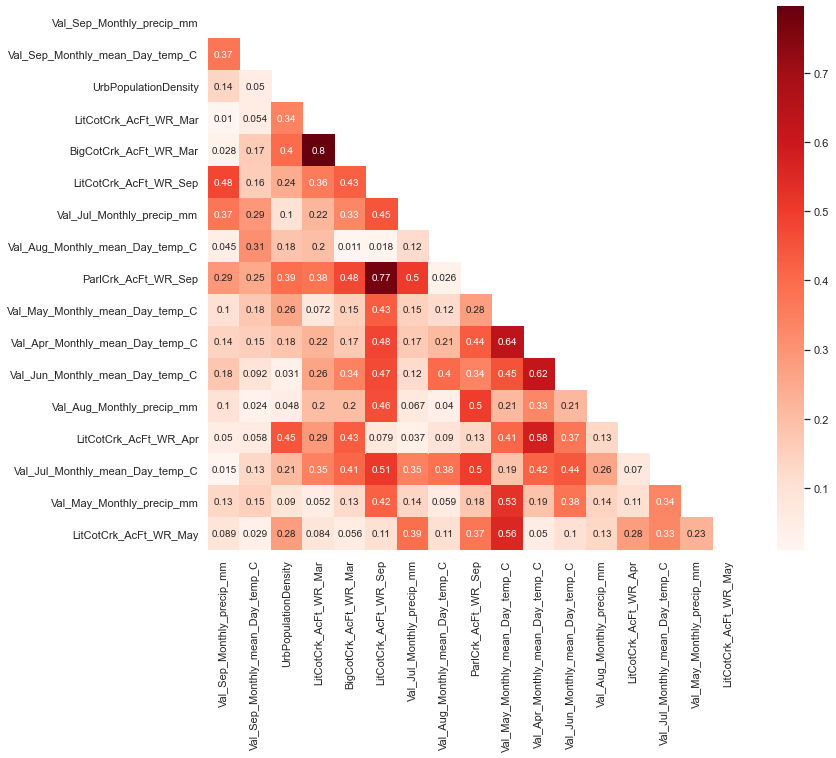

The outdoor Demand prediction RMSE is  11.657120389719092
The outdoor Demand prediction R2 is  0.8215668623621867
The Total Demand prediction RMSE is  18.88354715238881
The Total Demand prediction R2 is  0.7252475778329739
The Total Demand prediction MAE is  15.222645075153688
The Total Demand prediction MAPE is  0.04427967524078643 %
The final set of features for Sep are ['Val_Sep_Monthly_precip_mm', 'Val_Sep_Monthly_mean_Day_temp_C', 'Val_Aug_Monthly_mean_Day_temp_C', 'Val_May_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C', 'Val_Jun_Monthly_mean_Day_temp_C', 'Val_Jul_Monthly_mean_Day_temp_C']
The coefficients for each feature are [-0.96277559  8.09783096 11.93886891  3.30959512  2.97667022 -3.80143281
 -7.28232441]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh      RMSE
261         False         False           0.05                 0.8  11.65712
The model is automatically selecti

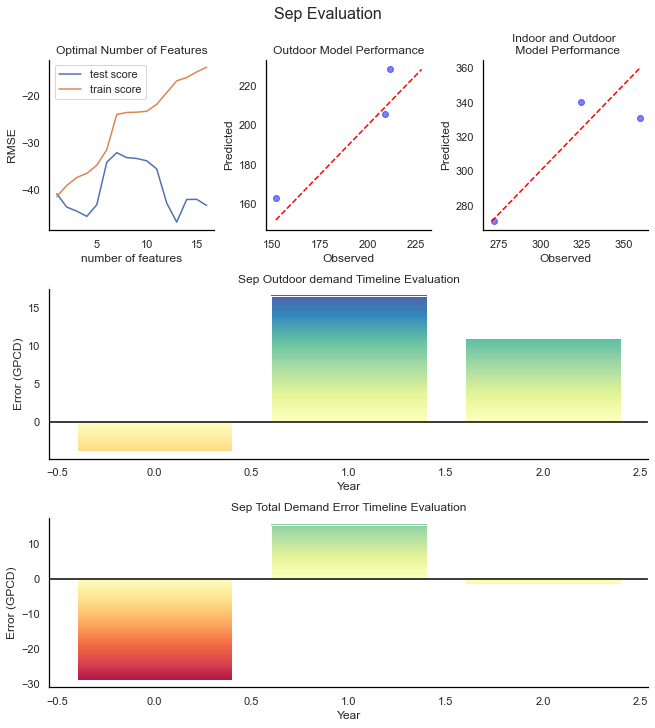

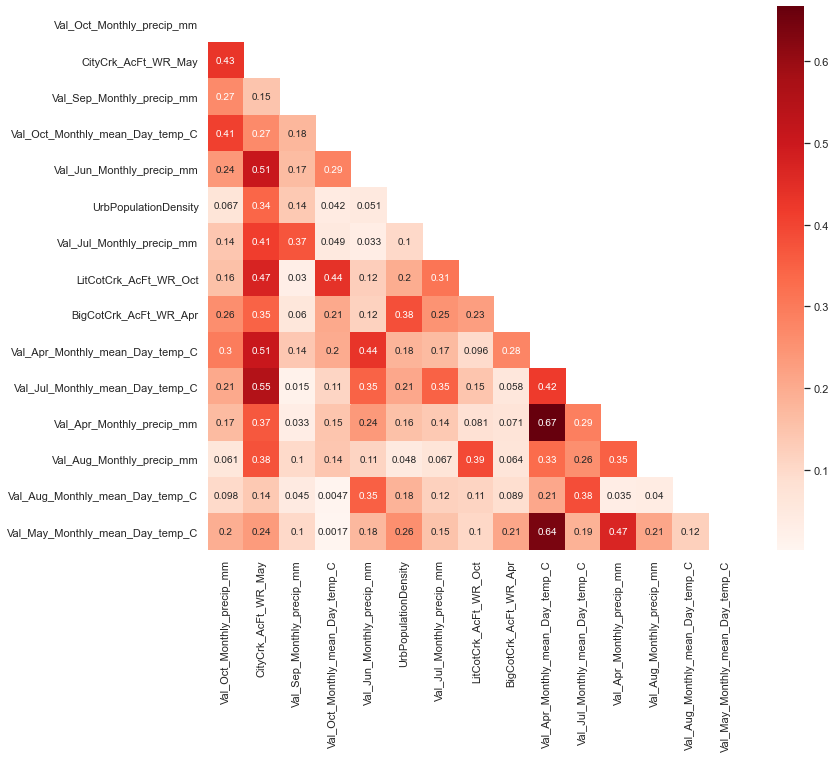

The outdoor Demand prediction RMSE is  20.247451744791704
The outdoor Demand prediction R2 is  -0.3613861494322399
The Total Demand prediction RMSE is  18.486774202431338
The Total Demand prediction R2 is  0.3062923569550261
The Total Demand prediction MAE is  17.59460641330412
The Total Demand prediction MAPE is  0.09536622302206858 %
The final set of features for Oct are ['Val_Oct_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C', 'Val_May_Monthly_mean_Day_temp_C']
The coefficients for each feature are [ 5.73659506  4.22206448 -2.02079688]
The best training parameters are below with their scoring method:  RMSE
     snowfeatures  conservation  cor_threshold  colinearity_thresh       RMSE
259         False         False           0.05                 0.7  20.247452
yes



<ipython-input-11-5f63722fb25d>:92: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'.pdf')
<ipython-input-11-5f63722fb25d>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


Total R2 is  0.9766188032681973
Total MAE is  16.64387014491631
Total RMSE is  19.547113475292928
Total MAPE is  4.365156659505094


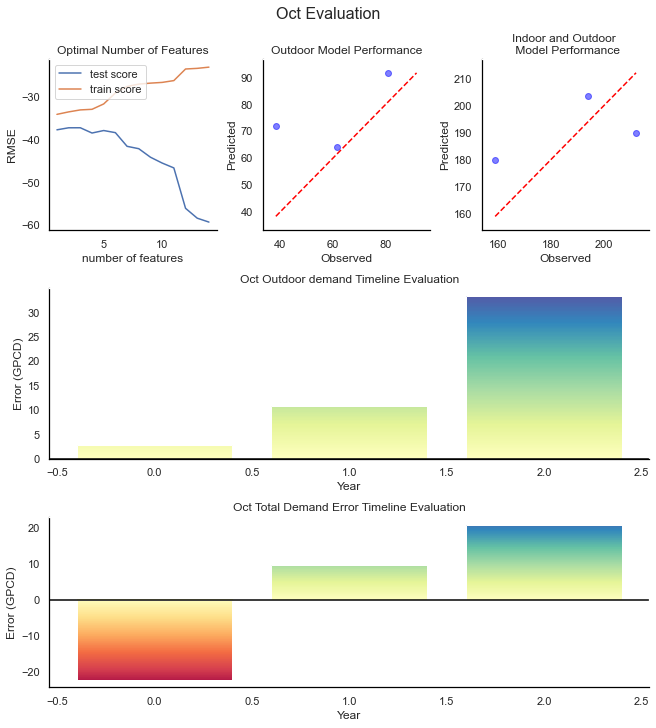

C:\Users\Ryan\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


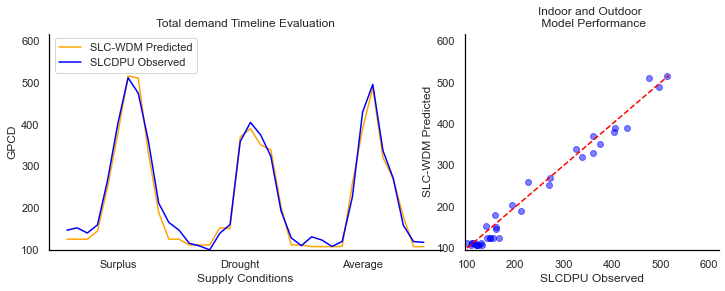

In [12]:
#Create the list of parameters to search through to optimize model performance
p_space = {
    'snowfeatures': [True, False],
    'conservation': [True, False],
    'cor_threshold': np.arange(0,0.7, 0.05),
    'colinearity_thresh': [0.65, 0.7, 0.75, 0.80, 0.85, 0.90]
}

Outdoor_Months=['Apr', 'May' , 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
IndoorMonths = ['Jan', 'Feb', 'Mar', 'Nov', 'Dec']



slc_val=copy.deepcopy(slc_test)
# calibrate and predict with the outdoor model
pbar = ProgressBar()
for i in pbar(Outdoor_Months):
    print('The model is automatically selecting features and calibrating the ', i, 'outdoor demand model.' )
    #put the month, use conservation_goal (-1: no, -2: yes) correlation threshold, colineariy threshold, CV, aplpha, model type, tuning method
    #put in the params, month, scoring method (R2, or RMSE for now)
    PerfDF, cv_results, cor, X_test_RFE, coef = Demand_Optimization(p_space, i, 'RMSE')
    
    colrem = slc_test[i].columns
    slc_val[i] = slc_val[i].reset_index(drop=True)
    slc_val[i] = pd.concat([slc_val[i], PerfDF], axis=1, join="inner")
    slc_val[i] = slc_val[i].set_index('Date')
    slc_val[i] = slc_val[i].drop(columns=colrem)

#Calibrate and predict with the indoor model
for i in IndoorMonths:
    slc_val = Indoor_Demand_Model(slc_val, i)


#Put it all together and display the results
#Demand_Forecast(slc_val)
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'Short_term_pred_gpcd', 'SLC-WDM')

In [172]:
#save predictions
np.save('ModelOutput/Slc_Pred_Low_Ave_High_WY.npy', slc_val)


In [13]:
slc_val = np.load('ModelOutput/Slc_Pred_Low_Ave_High_WY.npy', allow_pickle =True).item()

yes
Total R2 is  0.9766188032681973
Total MAE is  16.64387014491631
Total RMSE is  19.547113475292928
Total MAPE is  8.419832806068381


<ipython-input-12-18238038290e>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


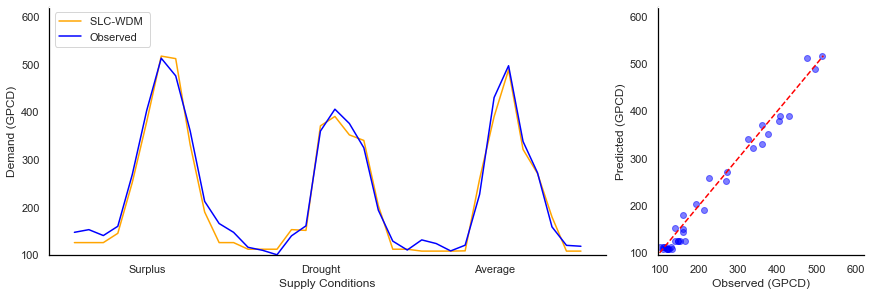

In [14]:
#Put it all together and display the results, need to adjust the term forecast depending on training data
df = pd.DataFrame()
Pred_Obs = Demand_Forecast(slc_val, True, df, 'y_pred_tot', 'y_test_tot', 'GPCD', 'MLR_Seasonal_term_pred_gpcd','SLC-WDM ')

In [15]:
from pandas.tseries.offsets import MonthEnd
cols = ['y_test_tot', 'y_pred_tot']
monthorder = ['Jan', 'Feb' , 'Mar', 'Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Pred_Obs = Pred_Obs[cols]

#input population into DF to calculate total water demands.
Population = []
UR_gpcd = []

slc_pred = copy.deepcopy(slc)

for i in monthorder:
    slc_train[i] = copy.deepcopy(slc[i].loc[:2010])
    slc_pred[i] = slc_pred[i].loc[2015:]
    slc_pred[i]['UR_gpcd'] = np.mean(slc_train[i]['Obs_gpcd'])
    Population.append(np.round(slc_pred[i]['Population'],0))
    
UR=pd.DataFrame()
for i in slc_pred:
    slc_pred[i]= pd.DataFrame(slc_pred[i]['UR_gpcd'])
    slc_pred[i]=slc_pred[i].reset_index()
    slc_pred[i]['M'] = datetime.datetime.strptime(i, "%b").month
    slc_pred[i]['D'] = 1
    slc_pred[i]['Date'] = pd.to_datetime(slc_pred[i].Year*10000+slc_pred[i].M*100+slc_pred[i].D,format='%Y%m%d')+MonthEnd(1)
    slc_pred[i].index = slc_pred[i].Date
    slc_pred[i]=slc_pred[i].drop(columns = ['M', 'D', 'Date', 'Year'])
    UR = UR.append(slc_pred[i])

UR=UR.sort_index()
Population = np.sort(np.array(Population).reshape(36,))

#place in to prediction df
Pred_Obs['Population'] = Population
Pred_Obs['UR_gpcd'] = UR['UR_gpcd']



#Now we can form some acre-feet predictions.
gpcd=['y_test_tot','y_pred_tot','UR_gpcd']
for i in gpcd:
    Pred_Obs[i+str('_AF')] = Pred_Obs[i]*Pred_Obs['Population']*9.33454e-5

    
remcol=['y_test_tot','y_pred_tot','UR_gpcd', 'Population']
Ann_Eval = Pred_Obs.drop(columns = remcol).copy()
Ann_Eval = Ann_Eval.resample('Y').sum()



no
Total R2 is  0.9765992771958528
Total MAE is  537.3515654137589
Total RMSE is  630.708116168728
Total MAPE is  8.419832806068387


<ipython-input-12-18238038290e>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


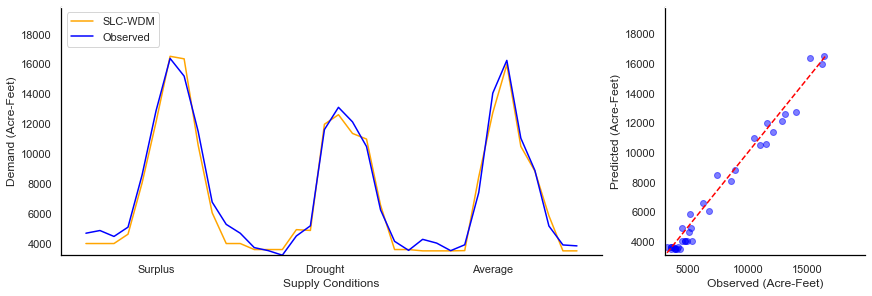

In [16]:
Pred_AF = Demand_Forecast(slc_val, False, Pred_Obs, 
            'y_pred_tot_AF', 'y_test_tot_AF', 'Acre-Feet', 'MLR_Seasonal_term_pred_AF', 'SLC-WDM')

no
Total R2 is  0.6283371213177069
Total MAE is  63.03597863247863
Total RMSE is  77.93344228795345
Total MAPE is  30.78863740465362


<ipython-input-12-18238038290e>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')


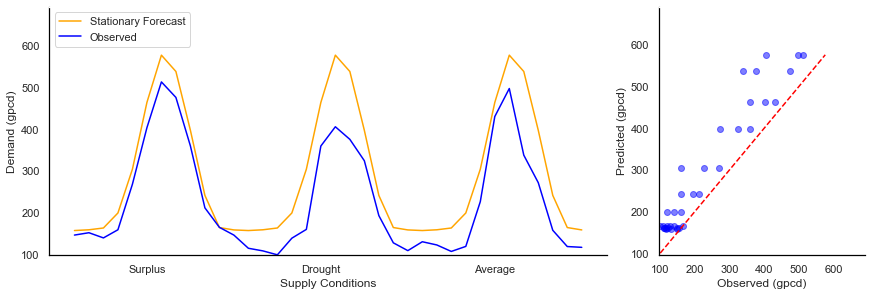

In [17]:
Pred_UR_GPCD = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd',
                'y_test_tot', 'gpcd', 'Stationary_Demand_Forecast_gpcd', 'Stationary Forecast')

In [18]:
Pred_UR_GPCD['StationaryError'] = ((Pred_UR_GPCD['UR_gpcd']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['SLCWDMError'] = ((Pred_UR_GPCD['y_pred_tot']-Pred_UR_GPCD['y_test_tot'])/Pred_UR_GPCD['y_test_tot'])*100
Pred_UR_GPCD['StationaryErrorAF'] = Pred_UR_GPCD['UR_gpcd_AF']-Pred_UR_GPCD['y_test_tot_AF']
Pred_UR_GPCD['SLCWDMErrorAF'] = Pred_UR_GPCD['y_pred_tot_AF']-Pred_UR_GPCD['y_test_tot_AF']
Evalcol = ['y_test_tot_AF', 'y_pred_tot_AF', 'StationaryError','SLCWDMError', 'StationaryErrorAF', 'SLCWDMErrorAF']
Eval = Pred_UR_GPCD[Evalcol]

Annual = Eval.resample('Y').sum()
Annual['S_Perror'] = Annual['StationaryErrorAF']/Annual['y_test_tot_AF']*100
Annual['SLCWDM_Perror'] = Annual['SLCWDMErrorAF']/Annual['y_test_tot_AF']*100
Annual

,y_test_tot_AF,y_pred_tot_AF,StationaryError,SLCWDMError,StationaryErrorAF,SLCWDMErrorAF,S_Perror,SLCWDM_Perror
Date,,,,,,,,
2015-12-31,100550.276769,94468.369531,139.858017,-112.889766,12207.162705,-6081.907237,12.140357,-6.048623
2016-12-31,81646.774954,81484.779554,512.522236,4.603096,32430.298904,-161.995400,39.720245,-0.198410
2017-12-31,86505.457871,83638.300459,455.384862,-48.858969,28891.579705,-2867.157412,33.398563,-3.314424


In [30]:
Eval

,y_test_tot_AF,y_pred_tot_AF,StationaryError,SLCWDMError,StationaryErrorAF,SLCWDMErrorAF
Date,,,,,,
2015-01-31,4709.274282,4020.242564,7.342278,-14.631378,345.767994,-689.031718
2015-02-28,4888.568674,4020.242564,4.579880,-17.762379,223.890584,-868.326110
2015-03-31,4493.545735,4020.242564,16.816118,-10.532955,755.639941,-473.303171
2015-04-30,5114.524352,4643.726952,24.996996,-9.205106,1278.477435,-470.797400
2015-05-31,8583.758986,8054.101919,13.335806,-6.170456,1144.713444,-529.657067
2015-06-30,12890.020382,12143.083636,14.946044,-5.794690,1926.548117,-746.936747
2015-07-31,16379.389681,16521.121898,12.453508,0.865308,2039.808677,141.732217
2015-08-31,15197.197243,16351.696472,13.006844,7.596790,1976.675810,1154.499229
2015-09-30,11502.006931,10581.546063,10.339270,-8.002611,1189.223590,-920.460868


In [4]:
#Get monthly stats for UR
URcol = ['y_test_tot', 'UR_gpcd']
Pred_UR_GPCD = Pred_UR_GPCD[URcol]
Pred_UR_GPCD['Month'] = Pred_UR_GPCD.index.month
UR = {}]/9++++

Irrmon = np.arange(4,11,1)
month = ['Apr', 'May', 'Jun' , 'Jul', 'Aug', 'Sep', 'Oct']
for i in Irrmon:
    UR[i]=Pred_UR_GPCD.loc[Pred_UR_GPCD['Month']==i]
    
for i in UR:
    
    print( calendar.month_name[i], 'Unit Rate Performance Metrics.')
    T_r2 = sklearn.metrics.r2_score(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])
    T_rmse= sklearn.metrics.mean_squared_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'], squared = False)
    T_mae= sklearn.metrics.mean_absolute_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])
    T_mape= sklearn.metrics.mean_absolute_percentage_error(UR[i]['y_test_tot'],UR[i]['UR_gpcd'])*100
        
    print('The Total Demand prediction RMSE is ', T_rmse)
    print('The Total Demand prediction R2 is ', T_r2)
    print('The Total Demand prediction MAE is ', T_mae)
    print('The Total Demand prediction MAPE is ', T_mape, '%') 
    


NameError: name 'Pred_UR_GPCD' is not defined

In [76]:
UR[4]

,y_test_tot,UR_gpcd,Month
Date,,,
2015-04-30,160.030,200.032692,4
2016-04-30,139.970,200.032692,4
2017-04-30,120.354,200.032692,4


no


<ipython-input-39-18238038290e>:92: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' +str(plotname)+'.pdf')
<ipython-input-39-18238038290e>:103: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
C:\Users\Ryan\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


Total R2 is  0.6235333383547133
Total MAE is  2043.3946037944281
Total RMSE is  2529.7467407378826
Total MAPE is  30.788637404653628


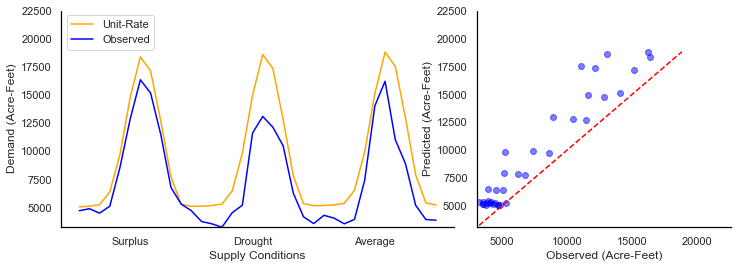

In [44]:
Pred_UR_AF = Demand_Forecast(slc_val, False, Pred_Obs, 'UR_gpcd_AF', 
                             'y_test_tot_AF', 'Acre-Feet', 'Seasonal_term_pred_UR_AF', 'Stationary Forecast')

In [58]:
'''I am putting a hard code on the limits here to make both figure have same color scale'''

plt.rcParams["axes.grid"] = False
plt.rcParams["axes.facecolor"] ='white'
#plt.rcParams["axes.edgecolor"]['bottom'] = 'black'

def gradientbars_sliced(bars, ymin, ymax):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
 #   ymin, ymax = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=0, origin='lower',
                  vmin= - max(np.abs(ymin), ymax), vmax=max(np.abs(ymin), ymax), cmap='Spectral_r')
    ax.axis([xmin, xmax, ymin, ymax])


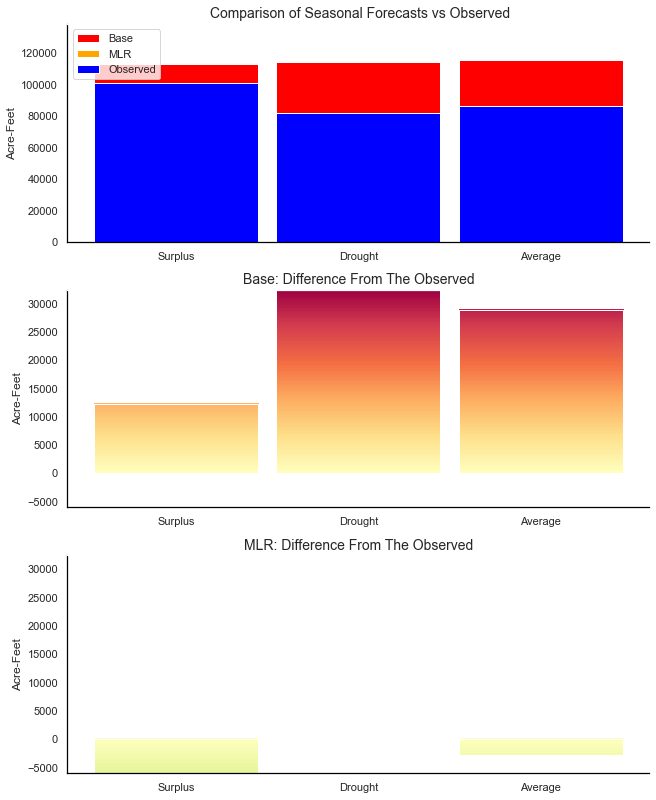

In [59]:
#Reduce width to increase space between bars
width = .9
widthM = 1
titlesize = 14

Ann_Eval['Supply'] = ['Surplus', 'Drought', 'Average']
Ann_Eval.index = Ann_Eval['Supply']

DayDF = Ann_Eval

fig, ax = plt.subplots(3,1, constrained_layout=True)
fig.set_size_inches(9,11)
DayDF['Error_SLC_WDM'] = DayDF.y_pred_tot_AF-DayDF.y_test_tot_AF
DayDF['Error_UR'] = DayDF.UR_gpcd_AF-DayDF.y_test_tot_AF


#Annual Figure

ax[0].bar(DayDF.Supply, DayDF.UR_gpcd_AF, width=width, 
    color='red', label='Base')
ax[0].bar(DayDF.Supply, DayDF.y_pred_tot_AF, width=width, 
    color='orange', label='MLR')
ax[0].bar(DayDF.Supply, DayDF.y_test_tot_AF, width=width, 
    color='blue', label='Observed')
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Acre-Feet')
ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')


Error_UR = ax[1].bar(DayDF.index, DayDF.Error_UR, width=width, 
    color='red', label='Base')
ax[1].set_ylabel('Acre-Feet')
ax[1].set_title('Base: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_UR, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')



Error_SLC_WDM = ax[2].bar(DayDF.Supply, DayDF.Error_SLC_WDM, width=width, 
    color='red', label='Unit-Rate')
ax[2].set_ylabel('Acre-Feet')
ax[2].set_title('MLR: Difference From The Observed', size = titlesize)
gradientbars_sliced(Error_SLC_WDM, min(min(DayDF.Error_UR), min(DayDF.Error_SLC_WDM)),
                    max(max(DayDF.Error_UR), max(DayDF.Error_SLC_WDM)))
ax[2].spines['bottom'].set_color('black')
ax[2].spines['left'].set_color('black')

fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/SLC_WDMvsUR.pdf')

In [60]:
#Make similar figure to one above, but include RFR and MLP.
#Make bars side by side rather than stacked

MLP = pd.read_excel('MLP_Models/MLP_Ann_Comp.xlsx')
RFR = pd.read_excel('RFR_Models/RFR_Ann_Comp.xlsx')
colrem = ['Supply', 'Supply.1', 'UR_gpcd_AF' ,'Error_UR', 'y_test_tot_AF']
MLP.index = MLP['Supply']
RFR.index = RFR['Supply']
MLP =MLP.drop(columns = colrem)
RFR = RFR.drop(columns = colrem)


MLP_col = ['MLP_pred_tot_AF', 'Error_MLP']
RFR_col = ['RFR_pred_tot_AF', 'Error_RFR']

MLP.columns = MLP_col
RFR.columns = RFR_col

#add mlp and RFR predictions to MLR/Ur
DayDF['RFR_pred'] =RFR['RFR_pred_tot_AF']
DayDF['RFR_Err'] =RFR['Error_RFR']

DayDF['MLP_pred'] =MLP['MLP_pred_tot_AF']
DayDF['MLP_Err'] =MLP['Error_MLP']

Preds = ['y_test_tot_AF' ,'y_pred_tot_AF', 'MLP_pred', 'RFR_pred', 'UR_gpcd_AF' ]
Err = ['Error_SLC_WDM', 'MLP_Err', 'RFR_Err', 'Error_UR' ]
labels = ['Observed','SLC-WDM' , 'MLP' , 'RFR', 'Stationary']
label2 = ['SLC-WDM' , 'MLP' , 'RFR', 'Stationary']


Preds = DayDF[Preds].copy()
Preds.columns = labels
Err = DayDF[Err].copy()
Err.columns =label2


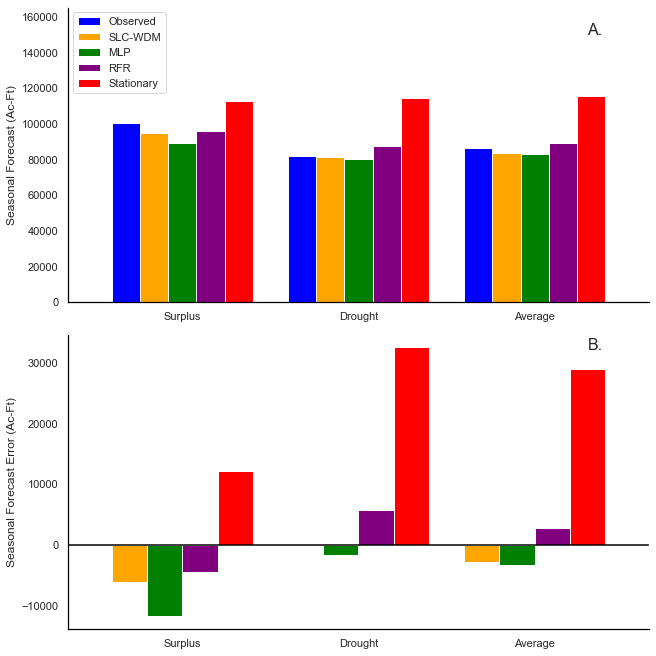

In [63]:
#Reduce width to increase space between bars
width = .8
widthM = 1
titlesize = 14

colorA  = ['blue', 'orange' ,'green' , 'purple', 'red']
colorB  = ['orange' ,'green' , 'purple', 'red']

fig, ax = plt.subplots(2,1, constrained_layout=True)
fig.set_size_inches(9,9)

#Annual Figure

Preds.plot(ax=ax[0], kind='bar', grid=True, width=width, color = colorA)
ax[0].legend(labels)
ax[0].set_ylim(0,max(max(Ann_Eval.y_test_tot_AF), max(Ann_Eval.y_pred_tot_AF),max(Ann_Eval.UR_gpcd_AF))*1.2)
#ax.annotate('Max Extra DC use: '+str(np.round(np.max(DayDF.ExtraDC),1))+'MGD', 
 #              xy=(DayDF.index[269], 150))
#ax.annotate('Max Daily DC use: '+str(np.round(np.max(DayDF.SLCDPU_DC_Water_Use),1))+'MGD', 
 #              xy=(DayDF.index[269], 130))
ax[0].legend(loc = 'upper left')
ax[0].set_ylabel('Seasonal Forecast (Ac-Ft)')
ax[0].set_ylim(0,np.max(Preds['Stationary'])+50000)
#ax[0].set_title(' Comparison of Seasonal Forecasts vs Observed', size = titlesize)
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].tick_params(labelrotation=0)
ax[0].xaxis.label.set_visible(False)
ax[0].text(2.3, 150000, "A.", size = 16)


Err.plot(ax=ax[1], kind='bar', grid=True, width =width, color=colorB, legend=False)
ax[1].set_ylabel('Seasonal Forecast Error (Ac-Ft)')
#ax[1].set_title('Error', size = titlesize)
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].tick_params(labelrotation=0)
ax[1].axhline(y=0, color='black', linestyle='-')
ax[1].xaxis.label.set_visible(False)
ax[1].text(2.3,32000, 'B.', size = 16)




fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLR_MLP_RFR_UR_compare.pdf')

In [64]:

#Make a function to put all of the predictions together
def Demand_Forecastgpcd_AF(gpcd, pdict, df, pred1, test1,pred2, test2, units1, units2, plotname, model):
    FinalDF=pd.DataFrame()
    if pdict is True:
        print('yes')
        for i in gpcd:
            FinalDF=FinalDF.append(gpcd[i])

        FinalDF=FinalDF.sort_index()
    else:
        print('no')
        FinalDF = df
        
    months = np.arange(1,6,1)
    Low = list()
    Ave=list()
    High = list()
    for i in months:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
        
    Low.append('Drought')
    Ave.append('Average')
    High.append('Surplus')
    
    months2 = np.arange(7,13,1)
    for i in months2:
        Low.append('Low'+str(i))
        Ave.append('Ave'+str(i))
        High.append('High'+str(i))
    
    Conditions = High+Low+Ave

    #adjust date range to improve figure
    #FinalDF['Date']= pd.date_range(start=pd.datetime(2015,1,1),end=pd.datetime(2018,1,1), freq='M')
    FinalDF['Date'] = Conditions
    
    FinalDF.index = FinalDF['Date']
    del FinalDF['Date']

    


    plotmin_tot1 = FinalDF[[pred1, test1]].min().min()
    plotmax_tot1 = FinalDF[[pred1, test1]].max().max()
    
    plotmin_tot2 = FinalDF[[pred2, test2]].min().min()
    plotmax_tot2 = FinalDF[[pred2, test2]].max().max()

    fig, ax = plt.subplots(2,6, constrained_layout=True)
    fig.set_size_inches(10,5)

    gs1 = ax[0,0].get_gridspec()
    # remove the underlying axes
    ax[0,0].remove()
    ax[0,1].remove()
    ax[0,2].remove()
    axbig = fig.add_subplot(gs1[0,:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    axbig.plot(FinalDF[pred1], color='orange', label= model)
    axbig.plot(FinalDF[test1],color='blue', label='Observed')
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot1-.9,plotmax_tot1*1.4)
    axbig.set_ylabel('Demand ('+ units1+')')
    axbig.legend(loc = 'upper left')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.text(35,600, 'A.', size = 16)
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        if i%12 != 5:
            tick.label1.set_visible(False)

    ax[0,3].remove()
    ax[0,4].remove()
    ax[0,5].remove()


    axbig2 = fig.add_subplot(gs1[0:,3:])
    axbig2.scatter(FinalDF[test1], FinalDF[pred1],color='blue', alpha=0.5)
    axbig2.set_ylabel('Predicted (' + units1+')' )
    axbig2.set_xlabel('Observed (' + units1+')')
    axbig2.set_ylim(plotmin_tot1*.95,plotmax_tot1*1.2)
    axbig2.set_xlim(plotmin_tot1*.95,plotmax_tot1*1.2)
   # axbig2.set_title('Indoor and Outdoor \n Model Performance')
    axbig2.plot([plotmin_tot1,plotmax_tot1],[plotmin_tot1,plotmax_tot1], color='red', linestyle='--' )
    #axbig2.set_xticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    #axbig2.set_yticks(np.arange(plotmin_tot, plotmax_tot, 100).round())
    axbig2.set_facecolor("white")
    axbig2.spines['bottom'].set_color('black')
    axbig2.spines['left'].set_color('black')
    axbig2.text(550,600, 'C.', size = 16)
    #ax[2].set_aspect('equal', adjustable='box')
    
    
    
    
    gs2 = ax[1,0].get_gridspec()
    # remove the underlying axes
    ax[1,0].remove()
    ax[1,1].remove()
    ax[1,2].remove()
    ax[1,3].remove()
    ax[1,4].remove()
    ax[1,5].remove()
    axbig = fig.add_subplot(gs2[1,:3])
    #axbig.set_title('Total demand Timeline Evaluation')
    axbig.plot(FinalDF[pred2], color='orange', label= 'Predicted')
    axbig.plot(FinalDF[test2],color='blue', label='Observed')
    axbig.set_xlabel('Supply Conditions')
    axbig.set_ylim(plotmin_tot2-.9,plotmax_tot2*1.2)
    axbig.set_ylabel('Demand ('+ units2+')')
    #axbig.legend(loc = 'upper left')
    axbig.set_facecolor("white")
    axbig.spines['bottom'].set_color('black')
    axbig.spines['left'].set_color('black')
    axbig.text(35,17000, 'B.', size = 16)
    #axbig.get_legend().remove()
    
    xticks = axbig.xaxis.get_major_ticks()
    for i,tick in enumerate(xticks):
        if i%12 != 5:
            tick.label1.set_visible(False)
    fig.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/MLR_Seasonal_gpcd_AF.pdf')

no


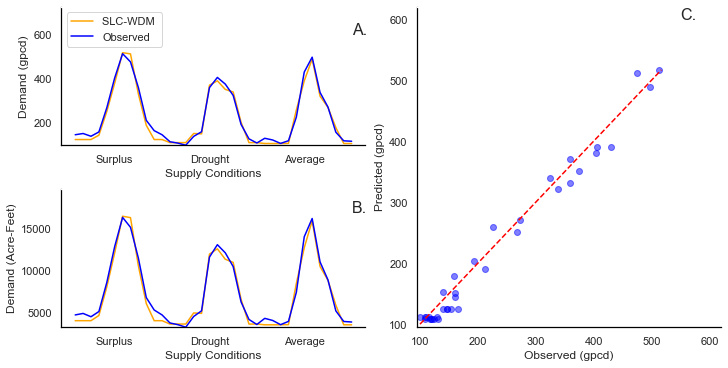

In [56]:
Demand_Forecastgpcd_AF(slc_val, False, Pred_Obs, 
            'y_pred_tot', 'y_test_tot','y_pred_tot_AF', 'y_test_tot_AF', 'gpcd', 'Acre-Feet', 'MLR_Performance', 'SLC-WDM ')

In [87]:
Months = ['Jan' , 'Feb' , 'Mar' , 'Nov' , 'Dec']
indoor = []
for i in Months:
    indoor.append(slc[i]['Obs_gpcd'])
    

indoor = pd.DataFrame(data= indoor).T
valyears = [2008,2015,2017]
indoor = indoor.drop(valyears)
indoor = pd.DataFrame(data = indoor.stack(), columns = ['gpcd']) 

print('The indoor mean is ', np.mean(indoor['gpcd']))


Months = ['Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct']

for i in Months:
    print(i)
    df = pd.DataFrame(data = slc[i]['Obs_gpcd'], columns = ['Obs_gpcd'])
    df = df.drop(valyears)
    print('Min monthly gpcd is ', np.min(df['Obs_gpcd']))
    print('Mean monthly gpcd is ', np.mean(df['Obs_gpcd']))
    print('Max monthly gpcd is ', np.max(df['Obs_gpcd']))
    print('STD monthly gpcd is ', np.std(df['Obs_gpcd']))
    print(' ')




The indoor mean is  155.9054666666666
Apr
Min monthly gpcd is  131.81
Mean monthly gpcd is  194.49033333333335
Max monthly gpcd is  266.67
STD monthly gpcd is  34.81686894627693
 
May
Min monthly gpcd is  162.68
Mean monthly gpcd is  299.2136666666667
Max monthly gpcd is  438.48
STD monthly gpcd is  61.68005071784196
 
Jun
Min monthly gpcd is  287.62
Mean monthly gpcd is  460.823
Max monthly gpcd is  575.55
STD monthly gpcd is  74.677865357369
 
Jul
Min monthly gpcd is  386.06
Mean monthly gpcd is  556.143
Max monthly gpcd is  696.01
STD monthly gpcd is  70.20522213007615
 
Aug
Min monthly gpcd is  344.54
Mean monthly gpcd is  521.425
Max monthly gpcd is  632.09
STD monthly gpcd is  65.81317344068232
 
Sep
Min monthly gpcd is  275.13
Mean monthly gpcd is  387.3406666666666
Max monthly gpcd is  485.58
STD monthly gpcd is  52.960191964237524
 
Oct
Min monthly gpcd is  178.02
Mean monthly gpcd is  235.73533333333333
Max monthly gpcd is  323.68
STD monthly gpcd is  41.472093648085284
 


In [88]:
seasondem = pd.DataFrame(columns = Months)
for i in Months:
    seasondem[i]=slc[i]['Obs_gpcd']
seasondem['SeasonMean'] = seasondem.mean(axis=1)

print('Min seasonal gpcd is ', np.min(seasondem['SeasonMean']))
print('Mean seasonal gpcd is ', np.mean(seasondem['SeasonMean']))
print('Max seasonal gpcd is ', np.max(seasondem['SeasonMean']))
print('STD seasonal gpcd is ', np.std(seasondem['SeasonMean']))

seasondem['SeasonTot'] = 0.00000307*seasondem['SeasonMean']*213*350000
print('Min seasonal gpcd is ', np.min(seasondem['SeasonTot']))
print('Mean seasonal gpcd is ', np.mean(seasondem['SeasonTot']))
print('Max seasonal gpcd is ', np.max(seasondem['SeasonTot']))
print('STD seasonal gpcd is ', np.std(seasondem['SeasonTot']))

Min seasonal gpcd is  280.0242857142857
Mean seasonal gpcd is  372.48
Max seasonal gpcd is  445.2157142857142
STD seasonal gpcd is  46.17989203456475
Min seasonal gpcd is  64088.73823499999
Mean seasonal gpcd is  85248.93888000003
Max seasonal gpcd is  101895.85270499998
STD seasonal gpcd is  10569.122620112781


In [89]:
#making heatmap figure for methods / July

CorFeat= ['UrbPopulationDensity', 'Val_Jul_Monthly_mean_Day_temp_C', 
              'Val_Apr_Monthly_mean_Day_temp_C', 'Val_May_Monthly_mean_Day_temp_C', 
              'LitCotCrk_AcFt_WR_Apr', 'ParlCrk_AcFt_WR_Jul']
July = slc['Jul'][CorFeat]
July = July.drop(valyears)

len(slc['Jul'].columns)

33

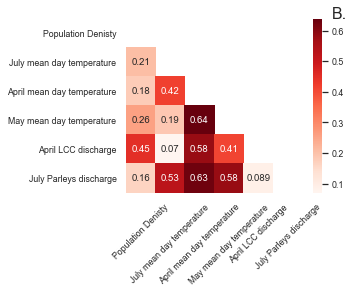

In [96]:
sns.set(style='white', font_scale = .8)


#subset these features out of main DF and put into cute heatmap plot
month = 'July'

DFcor = copy.deepcopy(July)

cor = np.abs(DFcor.corr())
cor = cor.mask(np.tril(np.ones(cor.shape)).astype(np.bool))
#remove colinearity
#cor = cor[cor.columns[cor.max() < 0.7]]
CorFeat=cor.columns
cor = cor.T
cor = cor[CorFeat]

x_axis_labels = ['Population Denisty', 'July mean day temperature', 
                'April mean day temperature', 'May mean day temperature',
                'April LCC discharge', 'July Parleys discharge'] # labels for x-axis
y_axis_labels = ['Population Denisty', 'July mean day temperature', 
                'April mean day temperature', 'May mean day temperature',
                'April LCC discharge', 'July Parleys discharge'] # labels for y-axis


# plotting cv results
plt.figure(figsize=(5,4))
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,
            xticklabels = x_axis_labels, yticklabels = y_axis_labels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.text(7,0, 'B.', size = 16)
plt.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/' + month + '_corMatrix.pdf')
plt.show()

<ipython-input-83-3c16467a24d4>:39: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


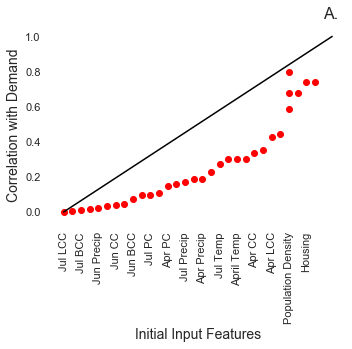

In [83]:
#Make a figure for July that visualizes correation process
Julcor = slc['Jul'].corr()
Julcor = pd.DataFrame(Julcor['Obs_gpcd'])
Julcor['Obs_gpcd'] = np.abs(Julcor['Obs_gpcd'])
Julcor = Julcor.sort_values(by= 'Obs_gpcd', ascending=True)
Julcor = Julcor[:-1]
index = ['Jul LCC', 'Jun PC', 'Jul BCC',
       'Jul CC', 'Jun Precip',
       'Jun Temp', 'Jun CC',
       'May PC', 'Jun BCC', 'May LCC',
       'Jul PC', 'May CC', 'Apr PC',
       'Mar PC', 'Jul Precip',
       'May BCC', 'Apr Precip',
       'May Precip', 'Jul Temp',
       'May Temp', 'April Temp',
       'Mar LCC', 'Apr CC', 'Mar BCC',
       'Apr LCC', 'Apr BCC',
       'Population Density', 'Population', 'Population Density', 'Housing',
       'Housing Density', 'Population Density']
Julcor.index = index


tsize = 14
#adjust the amount of ticks for clarity
import matplotlib.ticker as ticker
tick_spacing = 2


fig, ax = plt.subplots(1,1, constrained_layout=True)
fig.set_size_inches(5,5)

plt.scatter(x=Julcor.index, y = Julcor['Obs_gpcd'], c= 'red')
plt.ylabel('Correlation with Demand', size =tsize)
plt.xlabel('Initial Input Features', size = tsize)
plt.xticks(rotation = 90)
plt.plot([0.0, 31.0],[0.0, 1.0], c = 'black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.text(30,1.1, 'A.', size = 16)
plt.tight_layout()
plt.savefig('C:/Users/Ryan/Box/Dissertation/Paper1/Figs/Julcor.pdf')


In [78]:
Julcor.index

Index(['LitCotCrk_AcFt_WR_Jul', 'ParlCrk_AcFt_WR_Jun', 'BigCotCrk_AcFt_WR_Jul',
       'CityCrk_AcFt_WR_Jul', 'Val_Jun_Monthly_precip_mm',
       'Val_Jun_Monthly_mean_Day_temp_C', 'CityCrk_AcFt_WR_Jun',
       'ParlCrk_AcFt_WR_May', 'BigCotCrk_AcFt_WR_Jun', 'LitCotCrk_AcFt_WR_May',
       'ParlCrk_AcFt_WR_Jul', 'CityCrk_AcFt_WR_May', 'ParlCrk_AcFt_WR_Apr',
       'ParlCrk_AcFt_WR_Mar', 'Val_Jul_Monthly_precip_mm',
       'BigCotCrk_AcFt_WR_May', 'Val_Apr_Monthly_precip_mm',
       'Val_May_Monthly_precip_mm', 'Val_Jul_Monthly_mean_Day_temp_C',
       'Val_May_Monthly_mean_Day_temp_C', 'Val_Apr_Monthly_mean_Day_temp_C',
       'LitCotCrk_AcFt_WR_Mar', 'CityCrk_AcFt_WR_Apr', 'BigCotCrk_AcFt_WR_Mar',
       'LitCotCrk_AcFt_WR_Apr', 'BigCotCrk_AcFt_WR_Apr',
       'ResPopulationDensity', 'Population', 'PopulationDensity', 'Housing',
       'HousingDensity', 'UrbPopulationDensity'],
      dtype='object')